# Softmax algorithm

In this notebook, I am going to talk about the generalized logistic regression, which will be used to do the multiclassfication problem

In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 


%matplotlib notebook

## 1. Implement the Softmax algorithm

In [2]:
def Softmax(z):
    """
    Compute the Softmax function of z, where z could be w.x+b

    Arguments:
    z -- A scalar or numpy array of any size. This is the same as logistic regression argument
         The size of z is (num_of_class,num_of_samples)
    Return:
    mb -- MaxBoltz(z) size is (num_of_class,num_of_samples)
    """
    
    if (z.shape[0]==1):
        raise Exception("This function must at least has two classes")
    
    num_of_samples=z.shape[1]
    
    mb=np.exp(z)/np.sum(np.exp(z),axis=0).reshape(1,num_of_samples)
    return mb

In [3]:
a = np.array([[1, 2, 3, 6],  # sample 1
              [2, 4, 5, 6],  # sample 2
              [1, 2, 3, 6]]) # sample 1 again(!)


print (Softmax(a))


[[ 0.21194156  0.10650698  0.10650698  0.33333333]
 [ 0.57611688  0.78698604  0.78698604  0.33333333]
 [ 0.21194156  0.10650698  0.10650698  0.33333333]]


In [4]:
def initialize_with_zeros(dim,num_of_class):
    """
    This function creates a vector of zeros of shape (dim, num_of_class) for w and initializes b to [0,0,...,0].
    
    Argument:
    dim -- size of the w vector we want (or number of features in this case)
    
    Returns:
    w -- initialized vector of shape (dim, num_of_class)
    b -- initialized scalar (corresponds to the bias) [0,0,...,0]
    """
    
    w=np.zeros((dim,num_of_class))
    b=np.zeros((1,num_of_class))
    
    assert(w.shape == (dim, num_of_class))
    assert(b.shape == (1,num_of_class))
    
    return w,b

In [5]:
def mapping(x,target):
    
    """
    This is the mapping function.
    
    argument:
    x -- int of float
    
    return:
    1 if x==target
    0 else
    """
    if (x==target):
        return 1
    else:
        return 0
    
def buildY(a,target):
    vmap=np.vectorize(mapping)
    return np.squeeze(np.array([vmap(a,i) for i in target]))

In [6]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (number of features, num_of_class)
    b -- bias, (1,num_of_class)
    X -- data of size (number of features, number of samples)
    Y -- true "label" vector (containing 0 if is true, 1 if false) of size (1, number of samples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    num_of_samples=X.shape[1] ## number of samples
    A=Softmax(np.dot(w.T,X)+b.T)  ## vectorization version of MaxBoltz function for each example shape is (num_of_class, number of samples)
    YY=buildY(Y,range(w.shape[1]))  ## shape is (num_of_class, number of samples)
    cost=(-1/num_of_samples)*(YY*np.log(A)).sum()## log-likelihood cost for MaxBoltz function
    
    dw=(1.0/num_of_samples)*np.dot(X,(A-YY).T) ## this is the derivative wrt w_i shape=(number of features,num_of_class)
    db=(1.0/num_of_samples)*((A-YY).sum(axis=1)).T.reshape(1,YY.shape[0])  ## this is the derivative wrt b_i shape= (1,num_of_class)
    
    
    assert(dw.shape == w.shape)
    assert(db.shape == b.shape)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grade={"dw":dw,"db":db}
    return grade,cost
    
    

In [7]:
w=np.random.rand(3,2)
b=np.random.rand(1,2)

X=np.array([[1,2,3,4],[2,4,3,1],[3,1,4,6]])
Y=np.array([[0,1,0,0]])



print (propagate(w, b, X, Y))

({'dw': array([[-1.81687042,  1.81687042],
       [-1.25362468,  1.25362468],
       [-3.03060375,  3.03060375]]), 'db': array([[-0.66676384,  0.66676384]])}, 8.7344025076344671)


In [8]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (number_of_features, num_of_class)
    b -- bias, (1,num_of_class)
    X -- data of shape (number_of_features, number of samples)
    Y -- true "label" vector (containing 0 if true, 1 if false), of shape (num_of_class, number of samples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    num_of_iter=0
    
    costs=[]
    
    while (num_of_iter<num_iterations):
        
        ## this is the forward propagation
        grade,cost=propagate(w,b,X,Y)
        
        ## here is the update step, which we update the coefficient w, b for the next iteration
        w=w-learning_rate*grade['dw']
        b=b-learning_rate*grade['db']
        
        if (num_of_iter%100==0):
            costs.append(cost)
        
        if (print_cost==True and num_of_iter%100==0):
            print (cost)
            
        num_of_iter=num_of_iter+1
        
    params={"w":w,
           "b":b}
    
    grads={"dw":grade['dw'],
          "db":grade['db']}
    
    return params,grads,costs
    

In [9]:
w=np.array([[1,2],[4,5],[3,6]])
b=np.array([[0,0]])

X=np.array([[1,2,3,4],[2,4,3,1],[3,1,4,6]])
Y=np.array([0,1,1,0])


optimize(w, b, X, Y, 2000, 0.1, print_cost = False)

({'b': array([[ 1.26371882, -1.26371882]]),
  'w': array([[-0.91211954,  3.91211954],
         [ 2.89862917,  6.10137083],
         [ 6.65132179,  2.34867821]])},
 {'db': array([[-0.00118819,  0.00118819]]),
  'dw': array([[ 0.00306231, -0.00306231],
         [ 0.0015561 , -0.0015561 ],
         [-0.00252372,  0.00252372]])},
 [35.000129561715795,
  0.5758090075016834,
  0.3141185179226948,
  0.21216126369279523,
  0.15909009258178231,
  0.12684862925160403,
  0.10528820684985428,
  0.089897237491174314,
  0.078378595153953706,
  0.069444196284014492,
  0.062317643181172638,
  0.056503912406922929,
  0.051672867726788502,
  0.047596084349806125,
  0.04411058825392121,
  0.041097042835137321,
  0.03846609665697974,
  0.036149544878707439,
  0.034094437183347884,
  0.03225904824969051])

In [10]:
def find_class(A):
    """
    This is a help function that return the index 
    """
    vmax=-1; midx=-1
    for i in range(len(A)):
        if (A[i]>vmax):
            vmax=A[i]
            midx=i
    return midx


def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (number_of_features, num_of_class)
    b -- bias, (1,num_of_class)
    X -- data of size (number_of_features, number of samples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    ## get the number of examples
    m=X.shape[1]
    ## make predictions array for return
    Y_prediction=np.zeros((1,m),dtype=int)
    
    
    ## Softmax function
    A=Softmax(np.dot(w.T,X)+b.T) ## vectorization version of MaxBoltz function for each example shape is (num_of_class, number of samples)
    
    for i in range(A.shape[1]):
        
        Y_prediction[0,i]=find_class(A[:,i])
            
    return Y_prediction
    

In [27]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.1, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (number of features, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (, m_train)
    X_test -- test set represented by a numpy array of shape (number of features, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    num_feature=X_train.shape[0]
    
    ## initialize w and b
    w_0,b_0=initialize_with_zeros(num_feature,len(np.unique(Y_train)))
    
    ## find the final parameters for further calculation
    parameters, grads, costs=optimize(w_0, b_0, X_train, Y_train, num_iterations, learning_rate, print_cost = False)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples 
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    A=Softmax(np.dot(w.T,X_train)+b.T)
    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations,
        "A":A}
    
    return d

## 2. First example: 2 label class problem

This is the example that we discussed many times before. The male and female height and weight problem. We use it as a special example for only binary class problem

In [11]:
dflog = pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [12]:
dflog['gender']=dflog['Gender'].apply(lambda x:1 if x=='Male' else 0)

In [13]:
dflog.head()

,Gender,Height,Weight,gender
0,Male,73.847017,241.893563,1
1,Male,68.781904,162.310473,1
2,Male,74.110105,212.740856,1
3,Male,71.730978,220.042470,1
4,Male,69.881796,206.349801,1


<IPython.core.display.Javascript object>


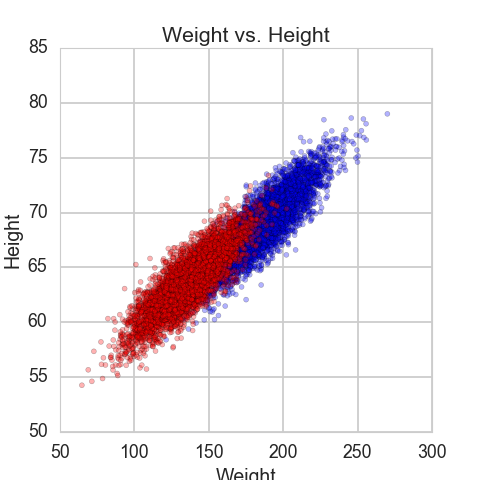

In [14]:
figure=plt.figure(figsize=(6,6))
plt.scatter(dflog['Weight'], dflog['Height'],c=dflog['gender'], cmap=cm_bright,alpha=0.3)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("Weight vs. Height")

In [15]:
## train test splitting

from sklearn.model_selection import train_test_split

# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(dflog[['Height','Weight']].values,dflog['gender'].values,random_state=5)

In [16]:
## reshape the dataset inorder to use my own algorithm

print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(7500, 2)
(2500, 2)
(7500,)
(2500,)


In [17]:
X_train=X_train.T
X_test=X_test.T
y_train.reshape((1,y_train.shape[0]))
y_test.reshape((1,y_test.shape[0]))

array([[0, 1, 1, ..., 0, 0, 1]])

In [18]:
## This is the standarization of the dataset, because the exponential function will be
## overflow we the argument x tends to negative infinite.



X_train=(X_train-X_train.mean(axis=1).reshape((2,1)))/X_train.std(axis=1).reshape((2,1))
X_test=(X_test-X_test.mean(axis=1).reshape((2,1)))/X_test.std(axis=1).reshape((2,1))

# X_train=X_train-X_train.max()
# X_test=X_test-X_test.max()

In [28]:
## train the model and test it!!


result=model(X_train, y_train, X_test, y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False)

train accuracy: 91.68 %
test accuracy: 92.56 %


## 3. Second Example: Multilabel class problem

In [32]:
origin=pd.read_csv('iris_data.csv',sep=',')

In [33]:
origin.head()

,Sepal_length,Sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [34]:
def pick(x):
    if x=='Iris-setosa':
        return int(0)
    elif x=='Iris-versicolor':
        return int(1)
    elif x=='Iris-virginica':
        return int(2)

In [35]:
origin['class']=origin['class'].apply(pick)

In [36]:
origin.head()

,Sepal_length,Sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [38]:
origin.columns

Index([u'Sepal_length', u'Sepal_width', u'petal_length', u'petal_width', u'class'], dtype='object')

In [39]:
## train test splitting

from sklearn.model_selection import train_test_split

# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(origin[['Sepal_length','Sepal_width','petal_length','petal_width']].values,origin['class'].values,random_state=5)

In [40]:
## reshape the dataset inorder to use my own algorithm

print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(112, 4)
(38, 4)
(112,)
(38,)


In [41]:
X_train=X_train.T
X_test=X_test.T
y_train.reshape((1,y_train.shape[0]))
y_test.reshape((1,y_test.shape[0]))

array([[1, 2, 2, 0, 2, 1, 0, 1, 0, 1, 1, 2, 2, 2, 0, 0, 2, 2, 0, 0, 1, 2,
        0, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 0, 1, 0, 0, 2]])

In [45]:
## This is the standarization of the dataset, because the exponential function will be
## overflow we the argument x tends to negative infinite.



X_train=(X_train-X_train.mean(axis=1).reshape((4,1)))/X_train.std(axis=1).reshape((4,1))
X_test=(X_test-X_test.mean(axis=1).reshape((4,1)))/X_test.std(axis=1).reshape((4,1))

# X_train=X_train-X_train.max()
# X_test=X_test-X_test.max()

In [50]:
## train the model and test it!!


result=model(X_train, y_train, X_test, y_test, num_iterations = 8000, learning_rate = 0.1, print_cost = False)

train accuracy: 99.1071428571 %
test accuracy: 94.7368421053 %


In [53]:
np.unique(result['Y_prediction_train'],return_counts=True)

(array([0, 1, 2]), array([38, 35, 39]))